# Spam Email Analysis


## Data Explortion

### Read data

In [1]:
em <- read.csv("gmailspamedited.csv",stringsAsFactors = F)
str(em)

'data.frame':	272 obs. of  18 variables:
 $ ï..Subject         : chr  "b'\\xe2\\x98\\x85 Hello, friend! Please open to see your Thanksgiving binge picks from Hulu'" "2 DAYS ONLY: Take 40% off everything" "b\"\\xe2\\xad\\x90\\xef\\xb8\\x8f Special invite from Hulu! We're confirming: King of the Hill Now Streaming\"" "Save $100 on Xbox One when you buy Red Dead Redemption 2." ...
 $ Return.Path.Address: chr  "@bounce.hulumail.com" "@em.express.com" "@bounce.hulumail.com" "@bounce.emailinfo2.bestbuy.com" ...
 $ Date               : chr  "11/16/2018 19:10" "11/2/2018 15:22" "11/9/2018 19:10" "11/2/2018 7:19" ...
 $ Reply.To.Address   : chr  "@hulumail.com" "@express.com" "@hulumail.com" "@emailinfo2.bestbuy.com" ...
 $ Content.Type       : chr  "multipart/alternative" "text/html" "multipart/alternative" "multipart/alternative" ...
 $ From.Address       : chr  "@hulumail.com" "@em.express.com" "@hulumail.com" "@emailinfo.bestbuy.com" ...
 $ Message            : int  16123 11935 14170 7901 2

### Preprocess the date

#### Creat Variables

##### Email Content


In [19]:
library(dplyr
       )
hashtml.func <- function(x,c1){
    x <- case_when(x[c1]=="multipart/alternative" ~ "1",x[c1]=="multipart/mixed" ~ "1",x[c1]=="multipart/related" ~ "1",x[c1]=="text/html" ~ "1",x[c1]=="text/plain" ~ "0")
}
em$hashtml <- apply(em,1,hashtml.func,c1='Content.Type')
hasattach.func <- function(x,c1){
    x <- case_when(x[c1]=="multipart/alternative" ~ "0",x[c1]=="multipart/mixed" ~ "1",x[c1]=="multipart/related" ~ "0",x[c1]=="text/html" ~ "0",x[c1]=="text/plain" ~ "0")
}
em$hasattach <- apply(em,1,hasattach.func,c1='Content.Type')

##### Compare Email Address

In [20]:
library(stringr)
rpavsfrom.func <- function(x){
    fa<-x['From.Address']
    fa<-str_split(fa,'@')[[1]][2]
    fasplit <-str_split(fa,'[.]')[[1]]
    fareal <- paste(str_split(fa,'[.]')[[1]][(length(fasplit)-1)],'.',str_split(fa,'[.]')[[1]][(length(fasplit))],sep = "")
    rp<-x['Return.Path.Address']
    rp<-str_split(rp,'@')[[1]][2]
    rpsplit <-str_split(rp,'[.]')[[1]]
    rpreal <- paste(str_split(rp,'[.]')[[1]][(length(rpsplit)-1)],'.',str_split(rp,'[.]')[[1]][(length(rpsplit))],sep = "")
    if (fareal == rpreal) {
        x = 1
    }else{
        x = 0
    }
    return(x)
}
em$rpavsfrom<-apply(em,1,rpavsfrom.func)

In [21]:
library(stringr)
replyvsfrom.func <- function(x){
    fa<-x['From.Address']
    fa<-str_split(fa,'@')[[1]][2]
    fasplit <-str_split(fa,'[.]')[[1]]
    fareal <- paste(str_split(fa,'[.]')[[1]][(length(fasplit)-1)],'.',str_split(fa,'[.]')[[1]][(length(fasplit))],sep = "")
    ra<-x['Reply.To.Address']
    ra<-str_split(ra,'@')[[1]][2]
    rasplit <-str_split(ra,'[.]')[[1]]
    rareal <- paste(str_split(ra,'[.]')[[1]][(length(rasplit)-1)],'.',str_split(ra,'[.]')[[1]][(length(rasplit))],sep = "")
    if (fareal == rareal) {
        x = 1
    }else{
        x = 0
    }
    return(x)
}
em$replyvsfrom<-apply(em,1,replyvsfrom.func)

In [22]:
country.func <- function(x,c1){
    if (x[c1] == "United States"){
        a = "US"
    }else{
        a= "outUS"
    }
    return (a)
}
em$Country <- apply(em,1,country.func,c1='Country')

##### Bin and Categorize the Time and the Day

In [23]:
library(lubridate)
weekday.func <- function(x,c1){
    weekday <- wday(as.Date(str_split(x[c1],' ')[[1]][1],format='%m/%d/%Y'))
    return(weekday)
}
em$Weekday <- apply(em,1,weekday.func,c1='Date')
em$Weekday <- factor(em$Weekday)
levels(em$Weekday) <- c("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")

In [24]:
time.func <- function(x,c1){
    time <- gsub(":", "", str_split(x[c1],' ')[[1]][2])
    return(time)
}
em$Time <- apply(em,1,time.func,c1='Date')
em$Time <- factor(round(as.numeric(em$Time)/100))

##### Convert the data to proper format

In [25]:
em$SPF <- factor(em$SPF,levels = c("pass","neutral","fail","temperror"))
em$DMARC <- factor(em$DMARC,levels = c("pass","fail","None"))
em$DKIM <- factor(em$DKIM,levels = c("pass","None"))
em$Country <- factor(em$Country)
em$IPv6.Indicator<-factor(em$IPv6.Indicator)
em$CAT <- factor(em$CAT)
em$Reputation <- factor(em$Reputation)
em$hashtml <- factor(em$hashtml)
em$hasattach <- factor(em$hasattach)
em$rpavsfrom <- factor(em$rpavsfrom)
em$replyvsfrom <- factor(em$replyvsfrom)

##### Set base level

In [26]:
em$Country <- relevel(em$Country,ref = "US")
em$Reputation <- relevel(em$Reputation,ref = "Unsuspicious")

##### Re-code the target to numeric

In [27]:
em$CAT <- as.numeric(em$CAT == "Spam")

### Explore the Relationship

In [28]:
set.seed(11)
selected.var <- c(7, 9, 10, 11, 12, 15, 16,17,18,19,20,21,22,23,24)
selected.df <- em[, selected.var]

In [29]:
emnum<-selected.df
levels(selected.df$SPF) <- c("1", "2", "3", "4")
emnum$SPF <- as.numeric(selected.df$SPF)
levels(selected.df$DMARC) <- c("1", "2", "3")
emnum$DMARC <- as.numeric(selected.df$DMARC)
levels(selected.df$DKIM) <- c("1", "2")
emnum$DKIM <- as.numeric(selected.df$DKIM)
levels(selected.df$Country) <- c("1", "2")
emnum$Country <- as.numeric(selected.df$Country)
levels(selected.df$IPv6.Indicator) <- c("1", "2")
emnum$IPv6.Indicator <- as.numeric(selected.df$IPv6.Indicator)
levels(selected.df$Reputation) <- c("1", "2")
emnum$Reputation <- as.numeric(selected.df$Reputation)
levels(selected.df$hashtml) <- c("1", "2")
emnum$hashtml <- as.numeric(selected.df$hashtml)
levels(selected.df$hasattach) <- c("1", "2")
emnum$hasattach <- as.numeric(selected.df$hasattach)
levels(selected.df$rpavsfrom) <- c("1", "2")
emnum$rpavsfrom <- as.numeric(selected.df$rpavsfrom)
levels(selected.df$replyvsfrom) <- c("1", "2")
emnum$replyvsfrom <- as.numeric(selected.df$replyvsfrom)
levels(selected.df$Weekday) <- c("1", "2", "3", "4", "5", "6", "7")
emnum$Weekday <- as.numeric(selected.df$Weekday)
levels(selected.df$Time) <- c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14","15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25")
emnum$Time <- as.numeric(selected.df$Time)

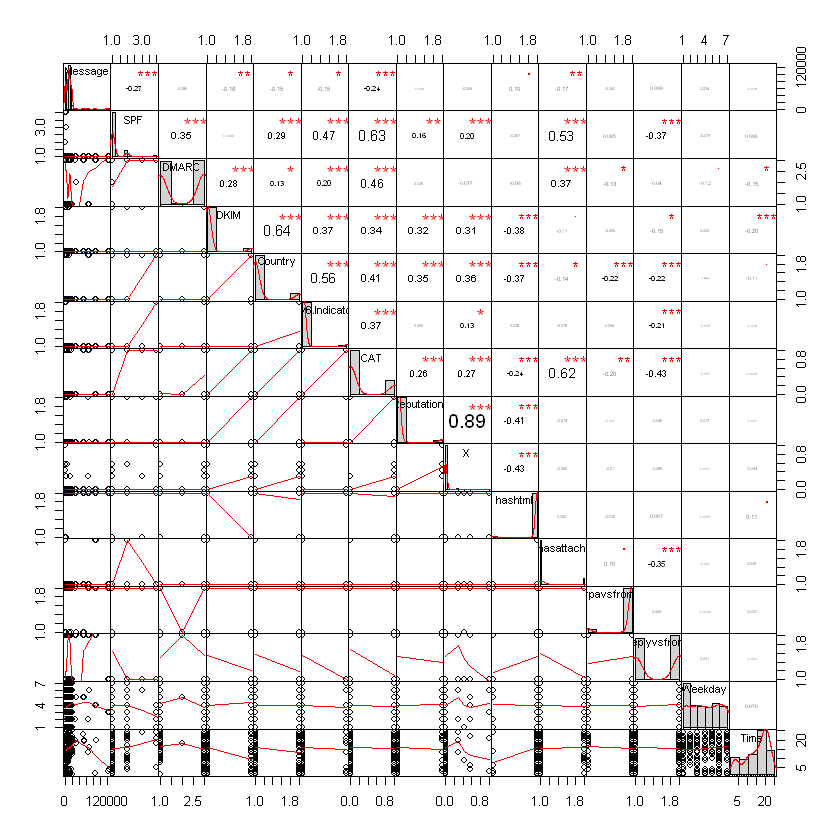

In [30]:
library("PerformanceAnalytics")
chart.Correlation(emnum, method="spearman",histogram=TRUE,pch="16")


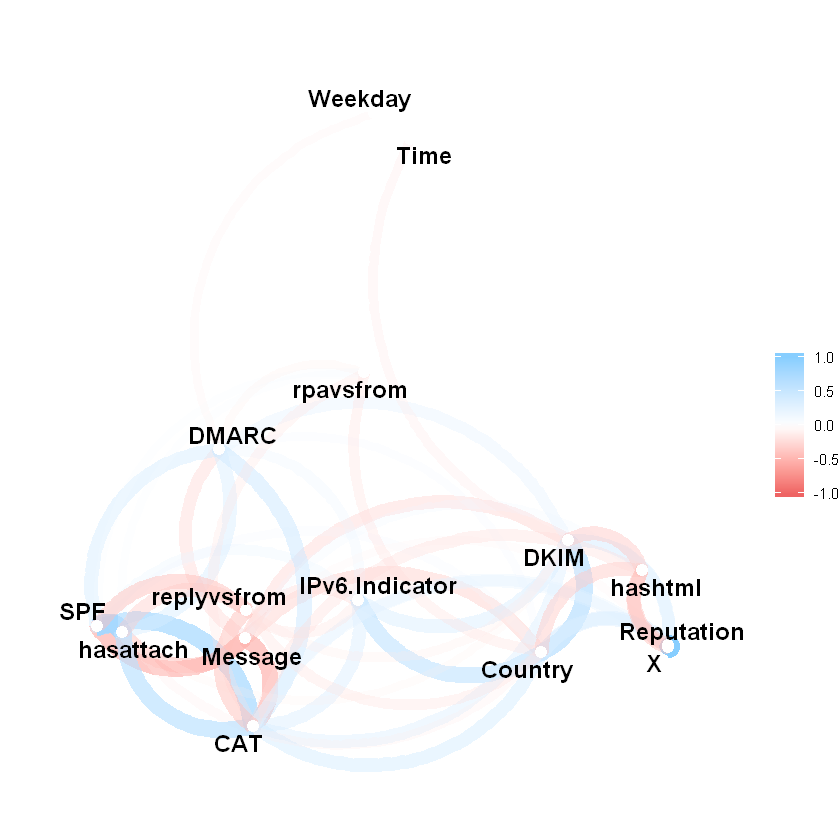

In [31]:
library(corrr)

emnum %>% cor(method="spearman") %>% network_plot(min_cor=0.1)

## Build Model
### Partition Data
#### Create Ttraining and Validation Sets

In [32]:
# partition the data
train.index <- sample(1:nrow(em), nrow(em)*0.6)  
train.df <- selected.df[train.index, ]
valid.df <- selected.df[-train.index, ]

In [33]:
str(train.df)

'data.frame':	163 obs. of  15 variables:
 $ Message       : int  18931 522 715 8726 1317 9824 12279 19856 12250 10136 ...
 $ SPF           : Factor w/ 4 levels "1","2","3","4": 1 2 1 1 1 1 1 1 1 1 ...
 $ DMARC         : Factor w/ 3 levels "1","2","3": 1 3 3 1 3 1 3 1 3 1 ...
 $ DKIM          : Factor w/ 2 levels "1","2": 1 1 2 1 2 1 1 1 1 1 ...
 $ Country       : Factor w/ 2 levels "1","2": 1 1 2 1 2 1 1 1 1 1 ...
 $ IPv6.Indicator: Factor w/ 2 levels "1","2": 1 1 2 1 1 1 1 1 1 1 ...
 $ CAT           : num  0 1 1 0 1 0 0 0 0 0 ...
 $ Reputation    : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 1 1 1 1 ...
 $ X             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ hashtml       : Factor w/ 2 levels "1","2": 2 2 2 2 1 2 2 2 2 2 ...
 $ hasattach     : Factor w/ 2 levels "1","2": 1 2 1 1 1 1 1 1 1 1 ...
 $ rpavsfrom     : Factor w/ 2 levels "1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ replyvsfrom   : Factor w/ 2 levels "1","2": 1 1 1 2 1 2 2 1 2 2 ...
 $ Weekday       : Factor w/ 7 levels "1","2","3","4",..: 5 

#### Fit a Logistic Regression Model

In [35]:
logit.reg <- glm(CAT ~ Message+DMARC+Country+DKIM+Reputation+replyvsfrom+rpavsfrom+Weekday, data = train.df, family = "binomial")
summary(logit.reg)


Call:
glm(formula = CAT ~ Message + DMARC + Country + DKIM + Reputation + 
    replyvsfrom + rpavsfrom + Weekday, family = "binomial", data = train.df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-3.09465  -0.18311  -0.04540  -0.00298   2.73259  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.880e+00  1.891e+00  -2.581 0.009848 ** 
Message      -2.864e-05  1.803e-05  -1.589 0.112145    
DMARC2       -1.101e+01  2.400e+03  -0.005 0.996340    
DMARC3        6.306e+00  1.445e+00   4.364 1.28e-05 ***
Country2      4.332e+00  1.767e+00   2.451 0.014247 *  
DKIM2        -3.987e+00  2.255e+00  -1.768 0.077077 .  
Reputation2   9.137e+00  2.607e+00   3.505 0.000457 ***
replyvsfrom2 -5.052e+00  1.214e+00  -4.162 3.16e-05 ***
rpavsfrom2   -2.141e+00  1.044e+00  -2.052 0.040209 *  
Weekday2      3.313e+00  1.764e+00   1.878 0.060359 .  
Weekday3      3.392e+00  1.544e+00   2.197 0.028011 *  
Weekday4      6.549e-01  1.684e+00  

#### Predction Validation

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



  threshold specificity sensitivity 
  0.3222076   0.9625000   0.9655172 


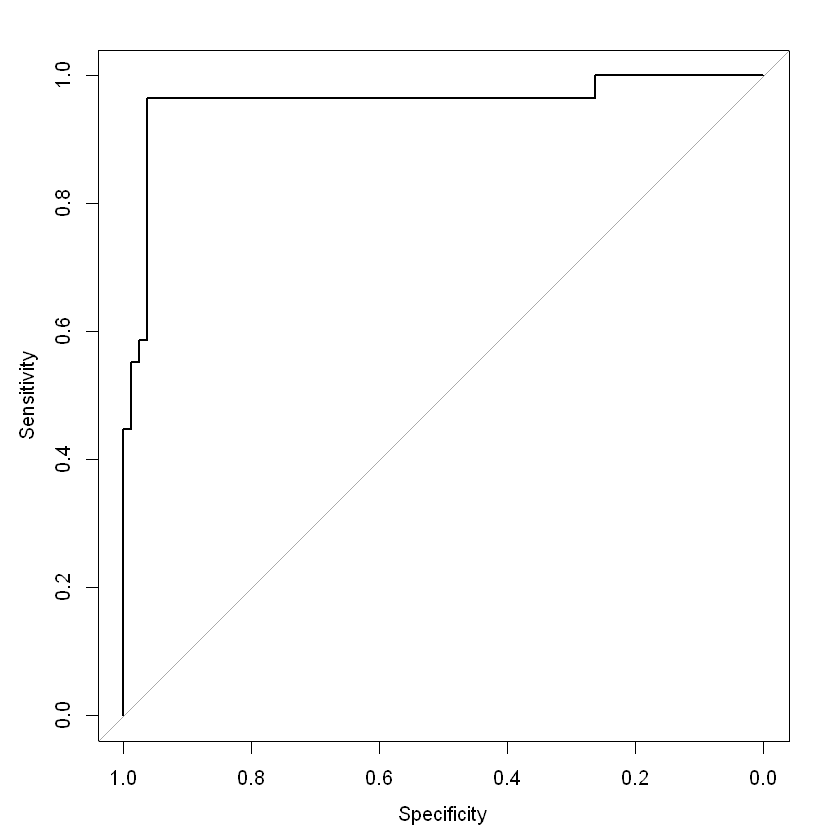

In [36]:
logit.reg.pred <- predict(logit.reg, valid.df,  type = "response")
library(pROC)
r <- roc(valid.df$CAT, logit.reg.pred)
plot.roc(r)
pred <- ifelse(logit.reg.pred > coords(r, x = "best")[[1]], 1, 0)
print(coords(r, x = "best"))

In [37]:
library(caret)
confusionMatrix(factor(pred), factor(valid.df$CAT), positive = "1")

Loading required package: lattice
Loading required package: ggplot2


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 77  1
         1  3 28
                                          
               Accuracy : 0.9633          
                 95% CI : (0.9087, 0.9899)
    No Information Rate : 0.7339          
    P-Value [Acc > NIR] : 2.433e-10       
                                          
                  Kappa : 0.9081          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9655          
            Specificity : 0.9625          
         Pos Pred Value : 0.9032          
         Neg Pred Value : 0.9872          
             Prevalence : 0.2661          
         Detection Rate : 0.2569          
   Detection Prevalence : 0.2844          
      Balanced Accuracy : 0.9640          
                                          
       'Positive' Class : 1               
                                          